# **Customer Churn Dectetion** 

![Churn-image](https://miro.medium.com/max/700/1*CxKl8-uPdExugRA4G-C9og.jpeg)

## **Problem Statement**

The globalization and advancements of telecommunication industry, exponentially raises the number of operators in the market that escalates the competition. In this competitive era, it has become mandatory to maximize the proﬁts periodically, for that various strategies have been proposed, namely, acquiring newcustomers, up-selling the existing customers & increasing the retention period of existing customers. Among all the strategies, retention of existing customers is least expensive as compared to others. In order to adopt the third strategy, companies have to reduce the potential customer churn. In this sense, the main reason of churn is the dissatisfaction of consumer service and support system. The key to unlock solutions to this problem is by forecasting the customers which are at risk of churning.

Therefore, in this project we develop a Streamlit App that utilizes a Machine Learning model(XGBoost) as an API to detect whether the customers from a Telco company will churns or not the company.

**Author: Luis Fernando Salazar Salinas Date: 10/09/2022**

### **Telco Customer churn dataset**
The IBM's Telco customers dataset contains information about a fictional telco company that provid home phone and internet services to 7043 customers in California. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index, whit a total of 32 features or predictor variables include in this dataset.

Source: [IBM](https://community.ibm.com/accelerators/catalog/content/Telco-customer-churn)

### **Install and Import the libraries**

In [ ]:
!pip install wget

In [ ]:
!pip install mlxtend

In [ ]:
!pip install xgboost --upgrade

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
!pip install hyperopt

In [ ]:
## Import libraries
import os
import random
import joblib
import wget
import warnings
warnings.simplefilter(action ="ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats.mstats import skew, kurtosis

from sklearn.preprocessing import StandardScaler, MinMaxScaler,Normalizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
#import sys
#sys.modules['sklearn.externals.joblib'] = joblib
#from mlxtend.feature_selection import ExhaustiveFeatureSelector
#from sklearndf.transformation import KBinsDiscretizerDF

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

random.seed(42)
np.random.seed(42)

### **Get Data**

In [ ]:
# URL
url = 'https://public.dhe.ibm.com/software/data/sw-library/cognos/mobile/C11/data/Telco_customer_churn.xlsx'
wget.download(url, '/tmp')

'/tmp/Telco_customer_churn.xlsx'

In [ ]:
# Import data to a dataframe
filepath = "/tmp/Telco_customer_churn.xlsx"
df = pd.read_excel(filepath)

### **Exploratory Data Analysis(EDA)**

- Structure:
 - Types of data 
 - General shape
 - Structure of no-numerical variables
 - Structure of numerical variables

- Quality:
 - Duplicated values
 - Missing values
 - Unwanted entries

- Content:
 - Statistical Summary
 - Feature Distribution
 - Features patters
 - Features correlaction
 

#### **Structure**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [ ]:
## Shape and structure
print(f"Data Shape:{df.shape}")
# set the max columns to none
pd.set_option('display.max_columns', None)
df.head(10)

Data Shape:(7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices
5,4190-MFLUW,1,United States,California,Los Angeles,90020,"34.066367, -118.309868",34.066367,-118.309868,Female,No,Yes,No,10,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Credit card (automatic),55.20,528.35,Yes,1,78,5925,Competitor offered higher download speeds
6,8779-QRDMV,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.023810,-118.156582,Male,Yes,No,No,1,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,Yes,1,100,5433,Competitor offered more data
7,1066-JKSGK,1,United States,California,Los Angeles,90024,"34.066303, -118.435479",34.066303,-118.435479,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes,1,92,4832,Competitor made better offer
8,6467-CHFZW,1,United States,California,Los Angeles,90028,"34.099869, -118.326843",34.099869,-118.326843,Male,No,Yes,Yes,47,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.35,4749.15,Yes,1,77,5789,Competitor had better devices
9,8665-UTDHZ,1,United States,California,Los Angeles,90029,"34.089953, -118.294824",34.089953,-118.294824,Male,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,30.20,30.2,Yes,1,97,2915,Competitor had better devices


##### No-numerical variables

In [ ]:
df.describe(include = "object").T

,count,unique,top,freq
CustomerID,7043,7043,3668-QPYBK,1
Country,7043,1,United States,7043
State,7043,1,California,7043
City,7043,1129,Los Angeles,305
Lat Long,7043,1652,"33.964131, -118.272783",5
Gender,7043,2,Male,3555
Senior Citizen,7043,2,No,5901
Partner,7043,2,No,3641
Dependents,7043,2,No,5416
Phone Service,7043,2,Yes,6361


##### Numerical variables

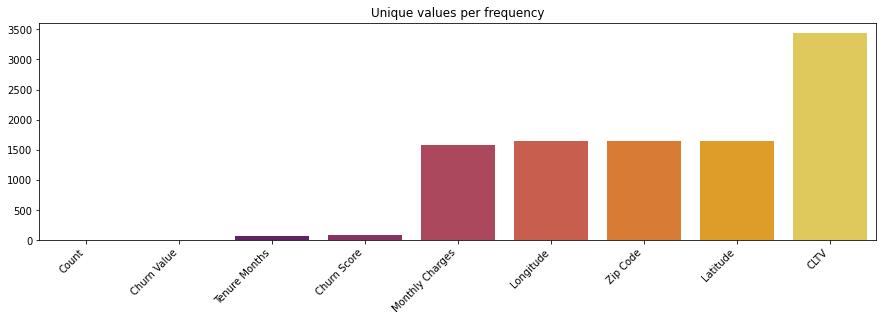

In [ ]:
uniq_values = df.select_dtypes('number').nunique().sort_values()

fig, ax = plt.subplots(figsize =(15,4))
sns.barplot(x = uniq_values.index, y = uniq_values, palette = 'inferno', ax = ax)
#ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Unique values per frequency');

#### **Quality**

##### Duplicate values

In [ ]:
##### Duplicate
n_duplicated = df.drop(columns = 'CustomerID').duplicated().sum()

print(f"There are {n_duplicated} duplicate values in dataset")

There are 0 duplicate values in dataset


##### Missing values

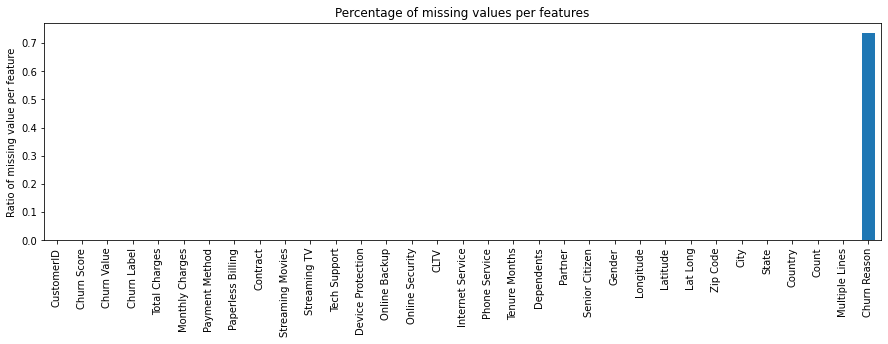

In [ ]:
## Per feature
(
    df
    .isnull()
    .mean()
    .sort_values()
    .plot(
        kind = "bar",
        figsize = (15,4),
        ylabel = "Ratio of missing value per feature",
        title = "Percentage of missing values per features"
    )

);

##### Wrangle funtion

In [ ]:
## Wrangle funtion
def wrangle(df):
  '''
  Remove missing values and unnecessary variables
  '''

  ## Unnecesarie data and leakage variables 
  drop_column = ['CustomerID','Count','Country','City','State','Churn Label', 'Zip Code', 'Churn Score', 'Lat Long', 'Total Charges']
  df.drop(columns = drop_column, inplace = True)

  ## Drop column with more than 50% of missing values 
  df.dropna(thresh = df.shape[0] * 0.5, axis= 1, inplace = True)

  return df

In [ ]:
df = wrangle(df)
print(f"Shape: {df.shape}")

Shape: (7043, 22)


##### Unwanted entries

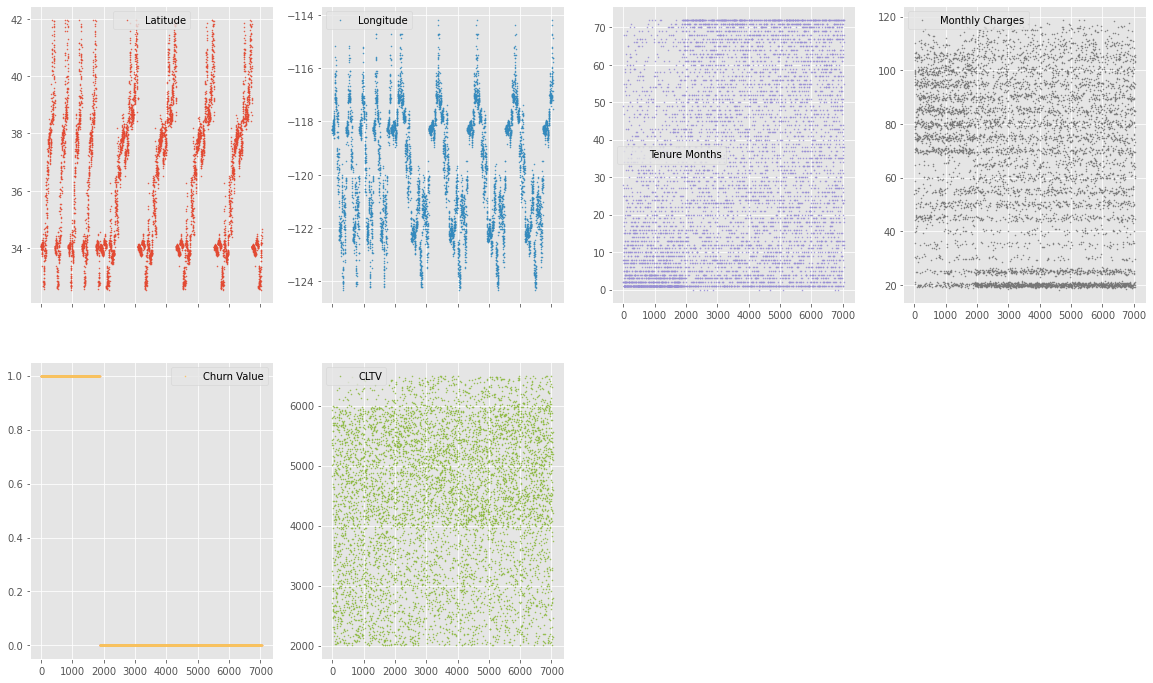

In [ ]:
## Numerical Features plot
df.plot(lw = 0, marker = ".", 
        subplots = True, 
        layout= (-1, 4),
        figsize = (20, 12),
        markersize = 1,
       );

##### **Observations**

- Removed the variables with more than 50% of their missing values.
- Removed the unnecessary and leakage variables
- Were not detect duplicate values
- Were not detect unwanted entries

####**Content**

##### Statistical summary

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,7043.0,36.282441,2.455723,32.555828,34.030915,36.391777,38.224869,41.962127
Longitude,7043.0,-119.798880,2.157889,-124.301372,-121.815412,-119.730885,-118.043237,-114.192901
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.000000,72.000000
Monthly Charges,7043.0,64.761692,30.090047,18.250000,35.500000,70.350000,89.850000,118.750000
Churn Value,7043.0,0.265370,0.441561,0.000000,0.000000,0.000000,1.000000,1.000000
CLTV,7043.0,4400.295755,1183.057152,2003.000000,3469.000000,4527.000000,5380.500000,6500.000000


##### Feature Distributions 

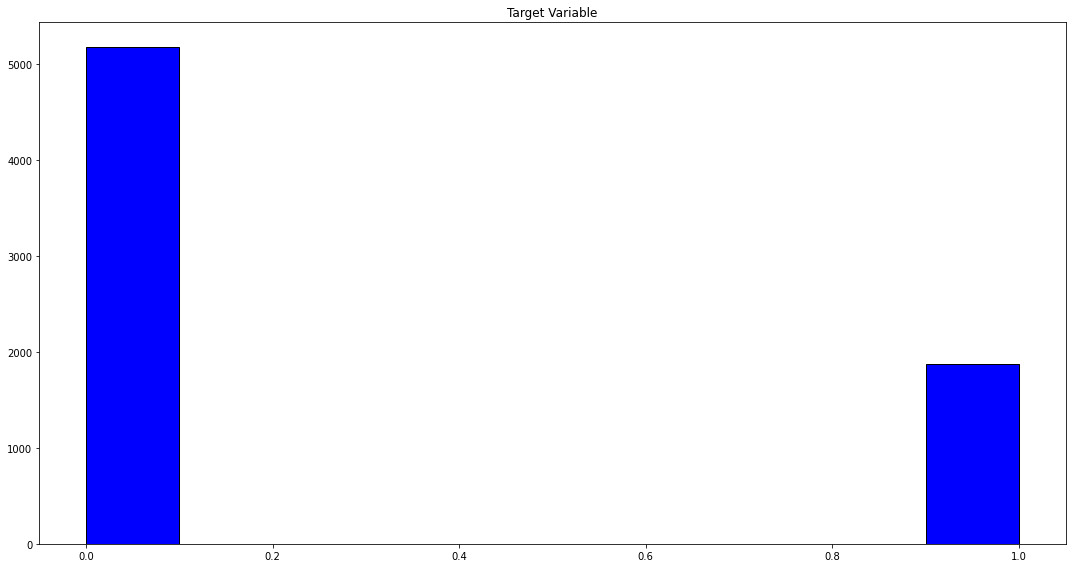

In [ ]:
df['Churn Value'].hist(figsize = (15, 8),
                       color = "blue",
                       grid = False,
                       edgecolor = "black")
plt.title("Target Variable")
plt.tight_layout();

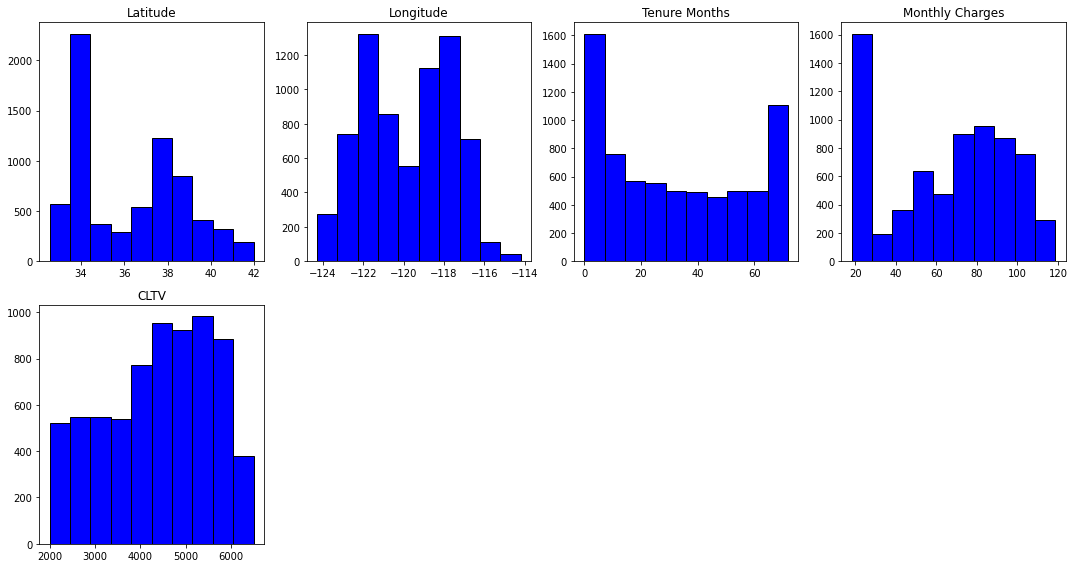

In [ ]:
df.drop(columns = 'Churn Value').hist(bins = 10,
                                      figsize = (15, 8),
                                      layout = (-1, 4),
                                      grid = False,
                                      color = "blue",
                                      edgecolor = "black",
                                      )
plt.tight_layout();

In [ ]:
# Kurtosis and skew
num_features = [num for num in df.select_dtypes("number").columns if num != "Churn Value"]

for c in num_features:
    kurt = kurtosis(df[c])
    Skew = skew(df[c])
    
    print(f"{c} Skew: {np.round(Skew, 2)}, Kurtosis: {np.round(kurt, 2)}")

Latitude Skew: 0.3, Kurtosis: -1.14
Longitude Skew: -0.04, Kurtosis: -1.14
Tenure Months Skew: 0.24, Kurtosis: -1.39
Monthly Charges Skew: -0.22, Kurtosis: -1.26
CLTV Skew: -0.31, Kurtosis: -0.93


##### Feature Patters

In [ ]:
## Continuos variables
cols_continuous = df.select_dtypes(include="number").nunique() >= 25
df_continuous = df[cols_continuous[cols_continuous].index]
df_continuous.shape

(7043, 5)

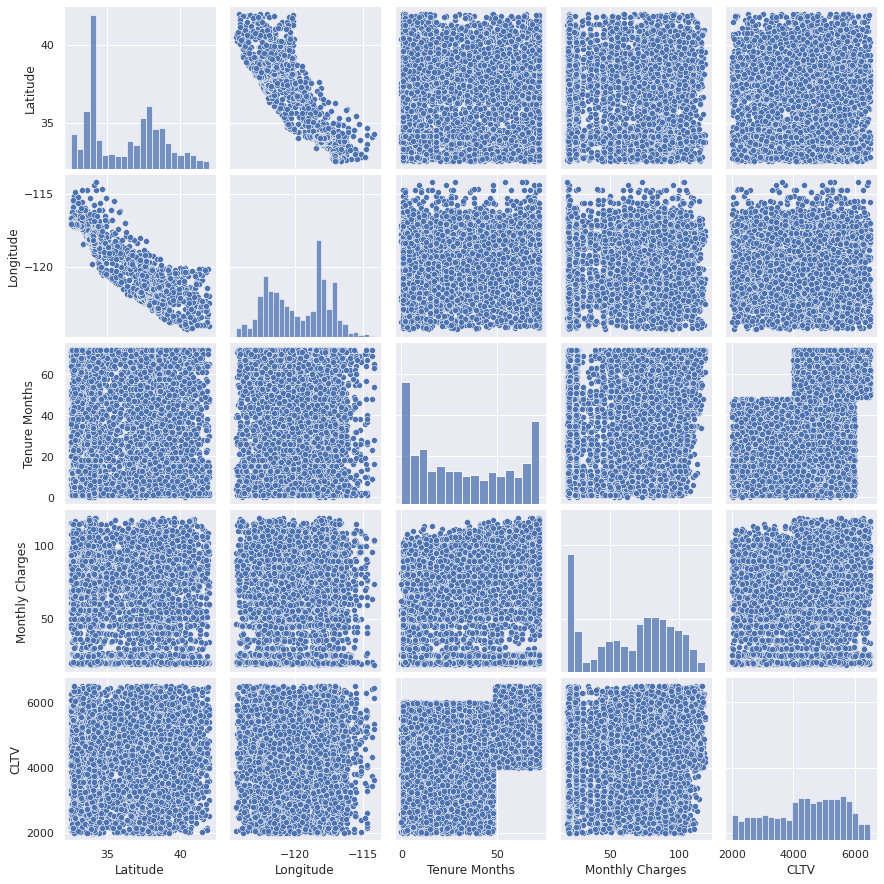

In [ ]:
## pairplot
sns.set(rc={'figure.figsize':(15,10)})
sns.pairplot(df_continuous)
sns.set_context('talk')
sns.set_style('white')

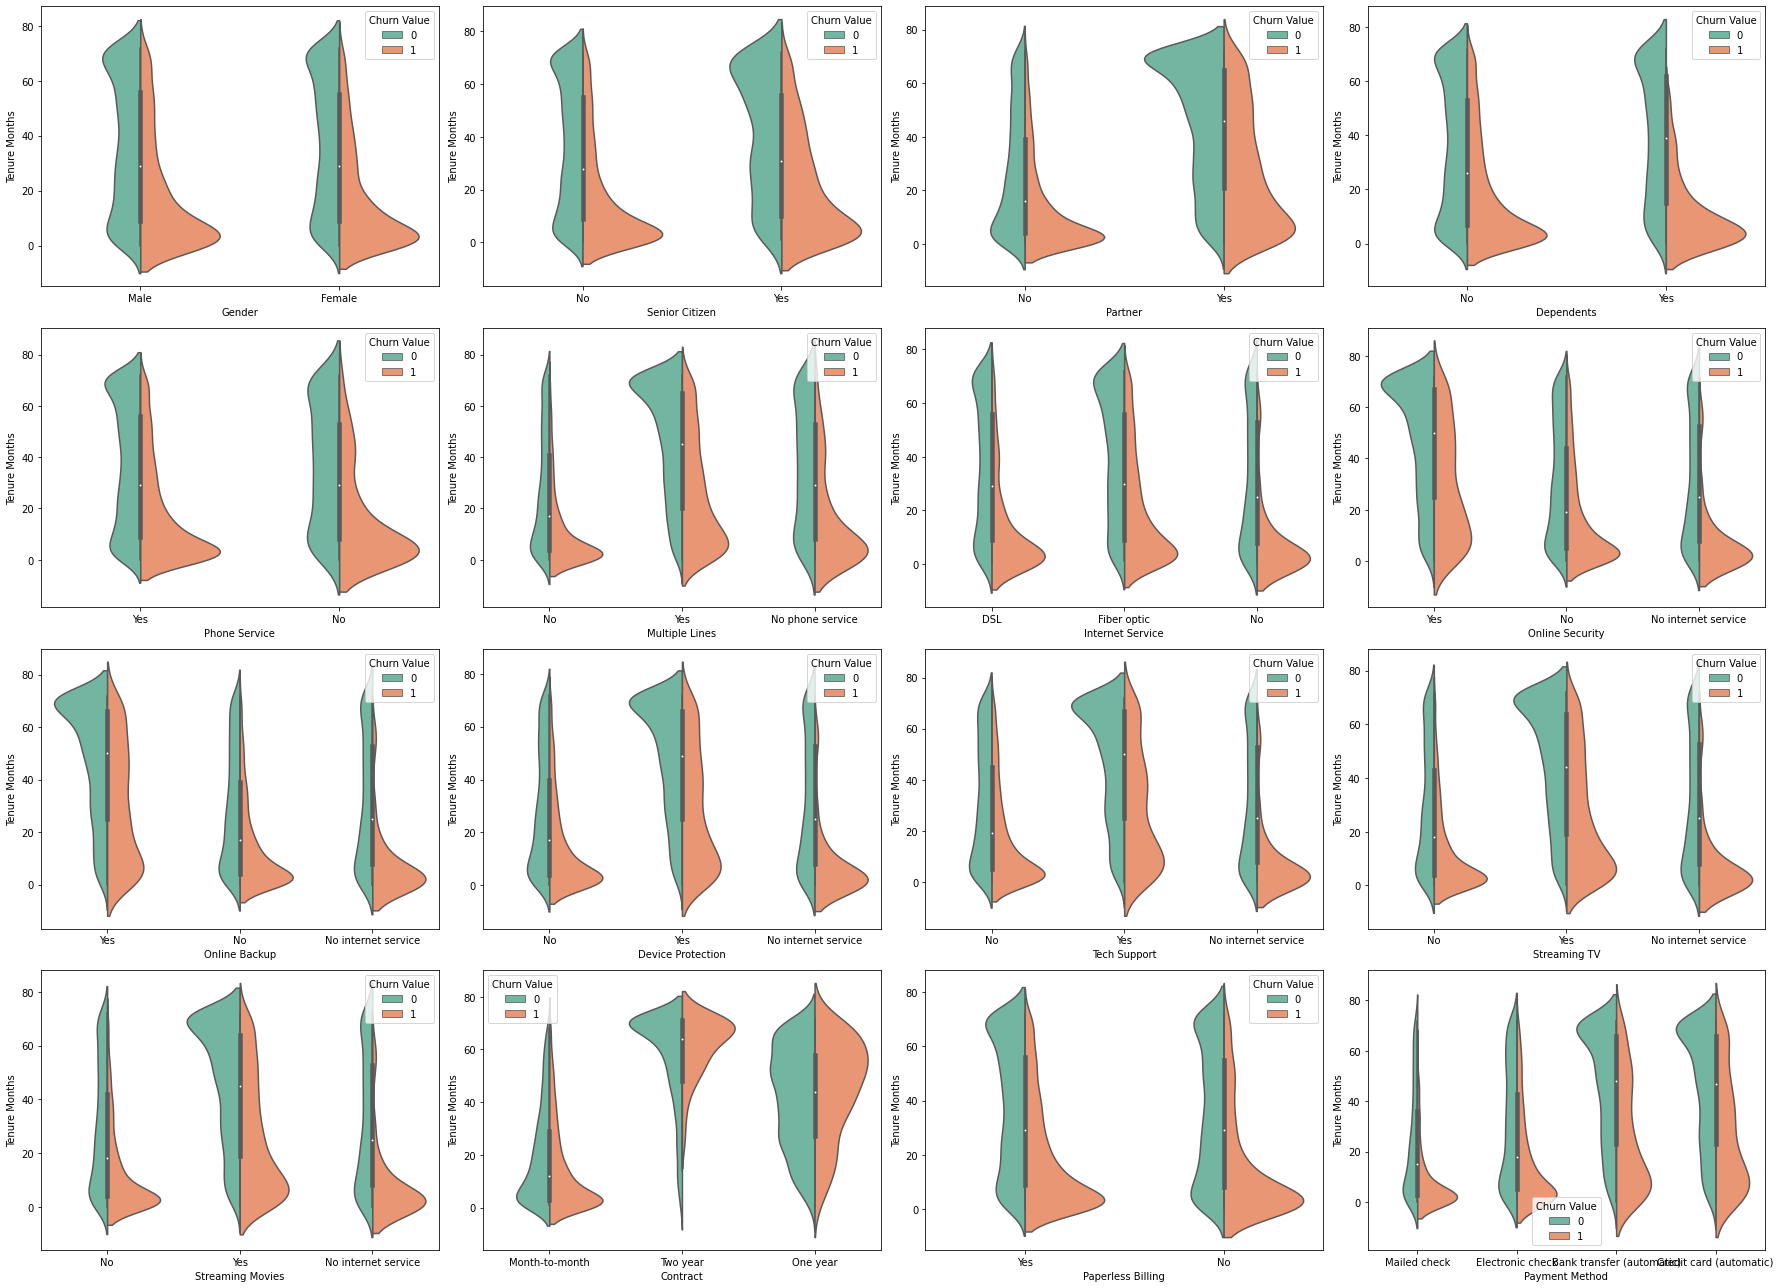

In [ ]:
## Violin plot for discrete 
y_values = "Tenure Months"
variables = df.select_dtypes("object")
fig, ax = plt.subplots(4, 4, figsize = (25, 18))

for colms, axis in zip(variables.columns, ax.ravel()):
  
  if colms != "Churn Value" :
        sns.violinplot(data = df, x = colms, 
                    y = y_values,
                    palette = 'Set2',
                    split = True,
                    hue = "Churn Value",
                    ax = axis
                 )
    
plt.tight_layout();

##### Transform categorical variables

In [ ]:
## Instance of LabelEncoder and LabelBinarizer
la = LabelEncoder()
lb = LabelBinarizer()
## Convert categorical variables 
cat_var_colm = list((df.select_dtypes('object').nunique() >= 3).index)
for c in cat_var_colm:
  df[c] = la.fit_transform(df[c])

## Convert bianary variables
bina_var_colm = list((df.select_dtypes('object').nunique() == 2).index)
for colm in bina_var_colm:
  df[colm] = lb.fit_transform(df[colm])

df.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Value,CLTV
0,33.964131,-118.272783,1,0,0,0,2,1,0,0,...,0,0,0,0,0,1,3,53.85,1,3239
1,34.059281,-118.307420,0,0,0,1,2,1,0,1,...,0,0,0,0,0,1,2,70.70,1,2701
2,34.048013,-118.293953,0,0,0,1,8,1,2,1,...,2,0,2,2,0,1,2,99.65,1,5372
3,34.062125,-118.315709,0,0,1,1,28,1,2,1,...,2,2,2,2,0,1,2,104.80,1,5003
4,34.039224,-118.266293,1,0,0,1,49,1,2,1,...,2,0,2,2,0,1,0,103.70,1,5340


##### Correlation
- Pearson's correlation coefficient
- Spearman's correlation coefficient

In [ ]:
## Crear una funcion para capturar los dos tipos de correlaction pearson y spearman 
def correlaction(df, coeffient_method = "pearson"):

  ## Coefficient of correlaction
  df_corr = df.drop(columns = 'Churn Value').corr(method= coeffient_method)

  ## labels
  labels =  np.where(np.abs(df_corr) > 0.75, "S",
                           np.where(np.abs(df_corr) > 0.5, "M",
                                    np.where(np.abs(df_corr) > 0.25, "W", "")))

  # Plots
  plt.figure(figsize=(15,8))
  sns.heatmap(df_corr, mask = np.eye(len(df_corr)), square = True,
              annot = labels, fmt = "", linewidths = .5,cmap ="vlag", 
              cbar_kws = {"shrink": 0.8}
              );

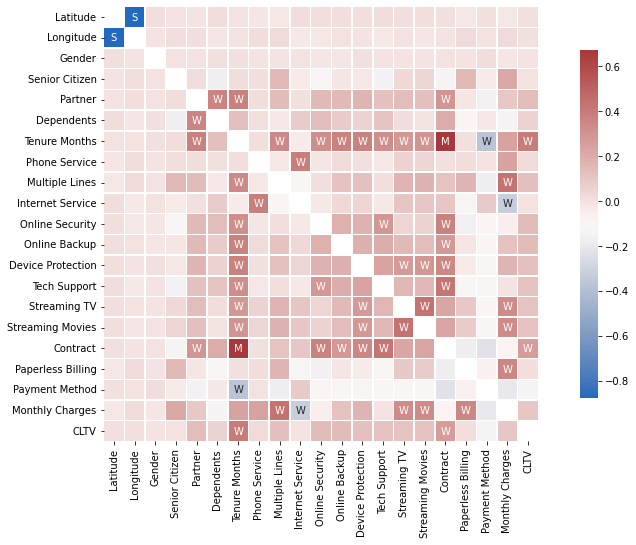

In [ ]:
# pearson
correlaction(df)

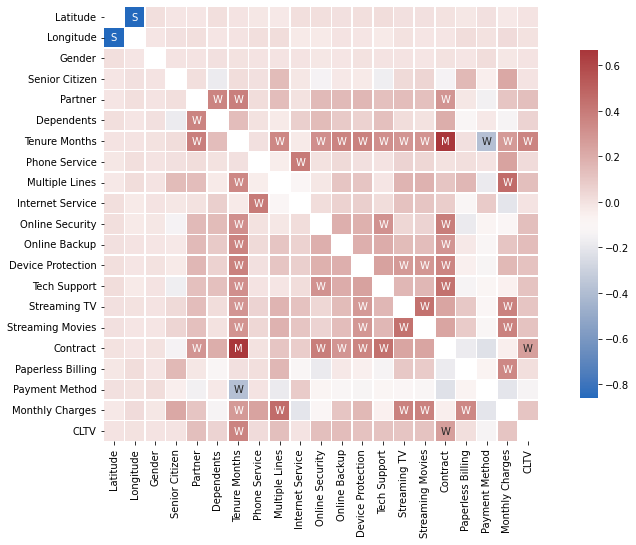

In [ ]:
## Spearman
correlaction(df, coeffient_method= 'spearman')

In [ ]:
## drop feature with higth correlaction
df.drop(columns = ['Latitude', 'Longitude'], inplace = True)

#### **Save the data**

In [ ]:
## Save data
df.to_csv("Telco-churn-datset-M.csv", index = False)

### **Data preprocessing** 

##### Split the data into features and labels

In [ ]:
label = 'Churn Value'
X = df.drop(columns = label)
y = df[label]

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (7043, 19)
Labels shape: (7043,)


##### Split the data into Train, Validation and Test set
- Proportions 80:10:10
- Method to split: StratifiedShuffleSplit 

In [ ]:
# Horizontal split with stratifiedshufflesplit to unbalance data
strat_shuf_split = StratifiedShuffleSplit(n_splits = 1,
                                          test_size = 0.2,
                                          random_state= 42)

train_idx, test_idx = next(strat_shuf_split.split(X, y))

## Create the dataframe
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

X_test  = X.iloc[test_idx]
y_test  = y.iloc[test_idx]


In [ ]:
# Validation data
strat_shuf_split = StratifiedShuffleSplit(n_splits = 1,
                                          test_size = 0.25,
                                          random_state= 42)

train_idx, val_idx = next(strat_shuf_split.split(X_train, y_train))

## Create the dataframe
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

X_val  = X.iloc[val_idx]
y_val  = y.iloc[val_idx]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4225, 19)
y_train shape: (4225,)
X_val shape:(1409, 19)
y_val shape: (1409,)
X_test shape:(1409, 19)
y_test shape: (1409,)


##### Method to handle Unbalanced data
**Synthetic Minority Oversampling Technique:**
SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. it focuses on the feature space to generate new instances with the help of interpolation between the the positive instances that lie together.

![SMOTE](https://editor.analyticsvidhya.com/uploads/77417image1.png)


In [ ]:
# OverSampling (SMOTE) method to unbalance data
from imblearn.over_sampling import SMOTE

def oversampling(alg, X, y):
    
    alg_over = alg(random_state = 42, n_jobs = -1)#sampling_strategy='not majority'
  
    X_train_over, y_train_over = alg_over.fit_resample(X, y)
    
    return X_train_over, y_train_over

In [ ]:
X_train, y_train = oversampling(SMOTE, X, y) 

print(f"X train over shape: {X_train.shape}")
print(f"y train over shape: {y_train.shape}")

X train over shape: (10348, 19)
y train over shape: (10348,)


##### Feature Selection
- Method: Recursive feature elimination with cross-validation(RFECV)
- Model: RandomForestClassifier

In [ ]:
def recursive_selection(X, y):
  # Model
  rfm = RandomForestClassifier(criterion = 'entropy', random_state = 42, n_jobs = -1)
  ## Recursive feature selection extimator
  rfe = RFECV(rfm, min_features_to_select =  17, cv = 5)
  # Fit 
  rfe = rfe.fit(X,y)

  ## Index of the best features
  features_idx = rfe.get_support(indices = True)

  return features_idx

In [ ]:
features_idx = recursive_selection(X_train, y_train)
X_train = X_train.iloc[: ,features_idx]
X_val = X_val.iloc[: ,features_idx]
X_test = X_test.iloc[: ,features_idx]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"X_test shape:{X_test.shape}")

X_train shape: (10348, 17)
X_val shape:(1409, 17)
X_test shape:(1409, 17)


### **Modelling**
Base line:
- LogisticRegression

Models:
- RandomForestClassifier
- ExtraTreeClassfier
- XGBClassifier

Models Performances:
- Classification Report:
  - LogLoss 
  - Accuracy 
  - Presicion
  - Recall
  - F1-Score
  - ROC-AUC

Hyperparameters Tuning (the best model):
- Bayes Optimizer (Hyperotp)
- Final Model:

Final model Performance with the test set
- Metrics:
 - Confusion Matrix
 - ROC-AUC Curve
 - F1-Score

##### Classification Report

In [ ]:
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

data_dict = {
    "Model": ["Baseline", "KNN", "XGBoost"],
    "Log-loss":[0,0,0],
    "Acuraccy":[0,0,0],
    "Precision":[0,0,0],
    "Recall": [0,0,0],
    "F1-score": [0,0,0],
    "AUC":[0,0,0]  
}

track_result = pd.DataFrame(data_dict, columns = ["Model","Log-loss",
                                                  "Acuraccy","Precision",
                                                 "Recall", "F1-score", "AUC"])
def model_results(model,y_val, y_pred):
    """ 
    Generates a classification report to monitor the models' performance, 
    computing the following metrics:
    
    - log-loss
    - accuracy
    - precision score
    - recall score
    - f1-score
    - roc-auc score
    """

    model_idx =  track_result[track_result["Model"] == model].index
    
    track_result.loc[model_idx, "Log-loss"] = log_loss(y_val, y_pred)
    track_result.loc[model_idx, "Acuraccy"] = accuracy_score(y_val, y_pred)
    track_result.loc[model_idx, "Precision"] = precision_score(y_val, y_pred)
    track_result.loc[model_idx, "Recall"] = recall_score(y_val, y_pred)
    track_result.loc[model_idx, "F1-score"] = f1_score(y_val, y_pred)
    track_result.loc[model_idx, "AUC"] = roc_auc_score(y_val, y_pred)
    
    return (track_result)

#### Baseline Model
- LogisticRegression

In [ ]:
## Train
lgr_model = LogisticRegression()
lgr_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
## Baseline performance
bs_pred = lgr_model.predict(X_val)

model_results('Baseline', y_val, bs_pred)

,Model,Log-loss,Acuraccy,Precision,Recall,F1-score,AUC
0,Baseline,8.50613,0.753726,0.601399,0.742981,0.664734,0.750983
1,KNN,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,XGBoost,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


#### **KNeighbors Model**
The k-nearest neighbors algorithm, also known as KNN or k-NN, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point. While it can be used for either regression or classification problems, it is typically used as a classification algorithm, working off the assumption that similar points can be found near one another.

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
## Training performance
acc_knn_train = knn_model.score(X_train, y_train)
acc_knn_val = knn_model.score(X_val, y_val)

print(f"KNeighbors Train Accuracy:{np.round(acc_knn_train,2)} \nKNeighbors  Validation Accuracy: {np.round(acc_knn_val,2)}")

KNeighbors Train Accuracy:0.86 
KNeighbors  Validation Accuracy: 0.83


In [ ]:
## KNeighbors performance
knn_pred = knn_model.predict(X_val)

model_results('KNN', y_val, knn_pred)

,Model,Log-loss,Acuraccy,Precision,Recall,F1-score,AUC
0,Baseline,8.506130,0.753726,0.601399,0.742981,0.664734,0.750983
1,KNN,6.030305,0.825408,0.675283,0.902808,0.772643,0.845167
2,XGBoost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### **Xgboost Model**
XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

In [ ]:
xgb_model = xgb.XGBClassifier(#subsample = 0.7,
                              #colsample_bytree = 0.4,
                              #max_depth = 4,
                              #scale_pos_weight= scale_pos_weight
                              )
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
## Training performance
acc_xgb_train = xgb_model.score(X_train, y_train)
acc_xgb_val = xgb_model.score(X_val, y_val)

print(f"XGB Train Accuracy:{round(acc_xgb_train,2)} \nXGB Validation Accuracy: {round(acc_xgb_val,2)}")

XGB Train Accuracy:0.96 
XGB Validation Accuracy: 0.94


In [ ]:
## Baseline performance
xgb_pred = xgb_model.predict(X_val)

model_results('XGBoost', y_val, xgb_pred)

,Model,Log-loss,Acuraccy,Precision,Recall,F1-score,AUC
0,Baseline,8.506130,0.753726,0.601399,0.742981,0.664734,0.750983
1,KNN,6.030305,0.825408,0.675283,0.902808,0.772643,0.845167
2,XGBoost,2.083630,0.939674,0.897059,0.922246,0.909478,0.935225


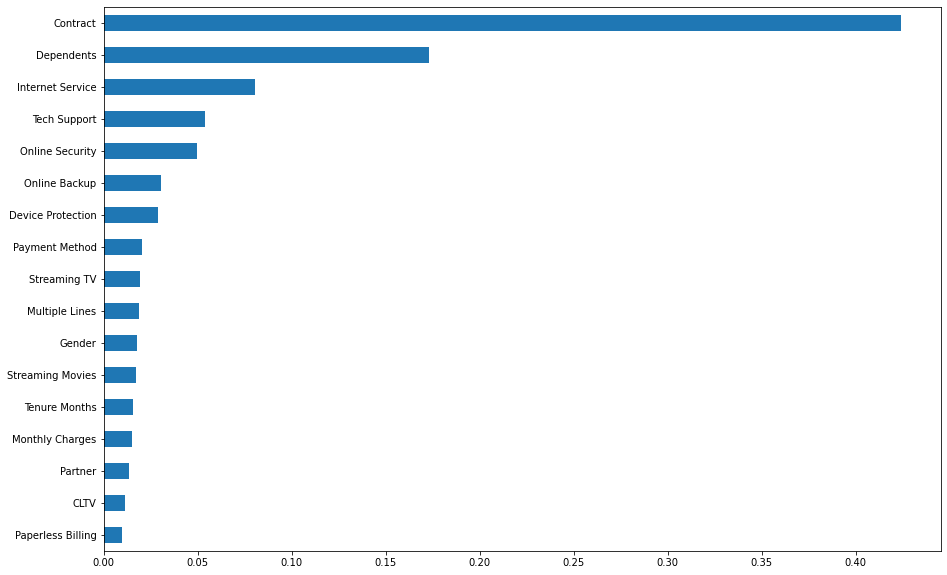

In [ ]:
## Feature importance 
importance_xgb = pd.Series(xgb_model.feature_importances_, index = X_train.columns)

#bar plot
importance_xgb.sort_values(ascending= True).plot(kind = 'barh', figsize = (15, 10));

##### **Observations**
- Xgboost was the model with the better performance with the validation set:
  - Accuracy: 0.93
  - F1-Score: 0.90
  - ROC-AUC: 0.93
- The variables that contribute most to the XGBoost model were:
 - Contract
 - Dependents
 - Internet service
 - Tech support 
 - Online security


#### **Hyperparameter Tuning**
**hyperopt**:
Hyperopt is a powerful python library for hyperparameter optimization developed by James Bergstra. Hyperopt uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters for a given model. It can optimize a model with hundreds of parameters on a large scale.

**Search Strategy**:
Bayesian optimization is a global optimization method for noisy black-box functions. Applied to hyperparameter optimization, Bayesian optimization builds a probabilistic model of the function mapping from hyperparameter values to the objective evaluated on a validation set. By iteratively evaluating a promising hyperparameter configuration based on the current model, and then updating it, Bayesian optimization aims to gather observations revealing as much information as possible about this function and, in particular, the location of the optimum.

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score

space = {
         'tree_method':'gpu_hist',
         'objective': 'binary:logistic',
         'subsample': hp.uniform('subsample', 0.4, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1.0),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1.0)),
         'min_child_weight': hp.quniform('min_child_weight',3, 10, 1),
         'max_depth': scope.int(hp.uniform('max_depth', 1, 12)),
         'gamma': hp.quniform('gamma', 0, 20, 1),
         'reg_alpha': hp.uniform('reg_alpha', 0.01, 4.0),
         'reg_lambda': hp.quniform('reg_lambda', 4, 40, 1),
         'n_estimators': scope.int(hp.uniform('n_estimators', 100, 2000)),
         #'eval_metric': 'auc',
         'seed': 100, 
         
    }


def objective(param):

  model = xgb.XGBClassifier(**param)

  accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean() 
 
  return {'loss': -accuracy, 'status': STATUS_OK }

    
trials = Trials()

best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            trials = trials
            )
best

100%|██████████| 100/100 [10:07<00:00,  6.07s/it, best loss: -0.8417222257245793]


{'colsample_bytree': 0.7767861352810786,
 'gamma': 0.0,
 'learning_rate': 0.0679877123774752,
 'max_depth': 11.7248583710846,
 'min_child_weight': 4.0,
 'n_estimators': 1027.0566435584287,
 'reg_alpha': 0.4205067157635871,
 'reg_lambda': 7.0,
 'subsample': 0.7930634621153184}

#### XGBoost Final Model

In [ ]:
### Train final model
final_model = xgb.XGBClassifier(
    tree_method = 'gpu_hist',
    objective = 'binary:logistic',
    learning_rate = best['learning_rate'],
    max_depth = int(best['max_depth']),
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    min_child_weight = int(best['min_child_weight']),
    reg_lambda = best['reg_lambda'],
    reg_alpha = best['reg_alpha'],
    gamma = int(best['gamma']),
    n_estimators = int(best['n_estimators']),
    seed = 100


)

final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7767861352810786, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0679877123774752,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=11,
              max_leaves=0, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=1027, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0.4205067157635871, reg_lambda=7.0, ...)

##### Prediction

In [ ]:
## Evaluate the model with the test set
# Prediction
y_pred = final_model.predict(X_test)
y_pred_pro = final_model.predict_proba(X_test)

##### Model performance with the Test Set

Accuracy: 0.9921930447125621 
Roc_Auc score: 0.9895631506884703
F1-score: 0.9852744310575635


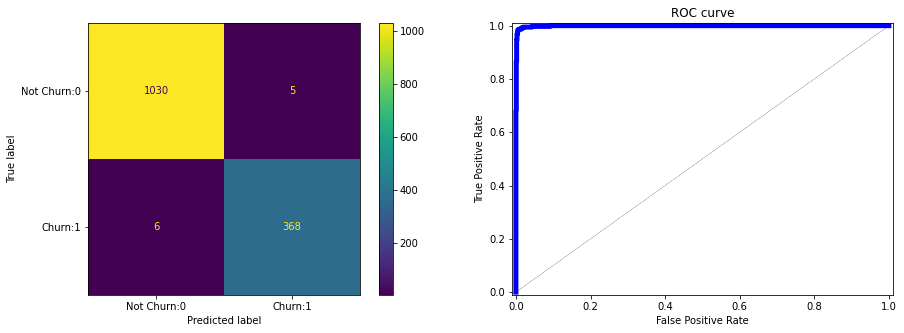

In [ ]:
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay
## Accuracy and roc_auc score
print(f"Accuracy: {accuracy_score(y_test, y_pred)} \nRoc_Auc score: {roc_auc_score(y_test, y_pred)}\nF1-score: {f1_score(y_test, y_pred)}")

## Roc curve
fpr, tpr, thr = roc_curve(y_test, y_pred_pro[:,1])

## plot
plt.figure(figsize =(15,5))
layout = (1,2)

cmd = plt.subplot2grid(layout,(0,0))
rc = plt.subplot2grid(layout,(0,1))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = cmd)
cmd.xaxis.set_ticklabels(["Not Churn:0", "Churn:1"])
cmd.yaxis.set_ticklabels(["Not Churn:0", "Churn:1"])

rc.plot(fpr, tpr, color ='blue', linewidth = 5)
rc.plot([0, 1],[0, 1], ls = '--', color = 'black', lw = .3)
rc.set(xlabel = 'False Positive Rate',
       ylabel = 'True Positive Rate',
       xlim =[-.01, 1.01], ylim =[-.01, 1.01],
       title = 'ROC curve')

plt.show()

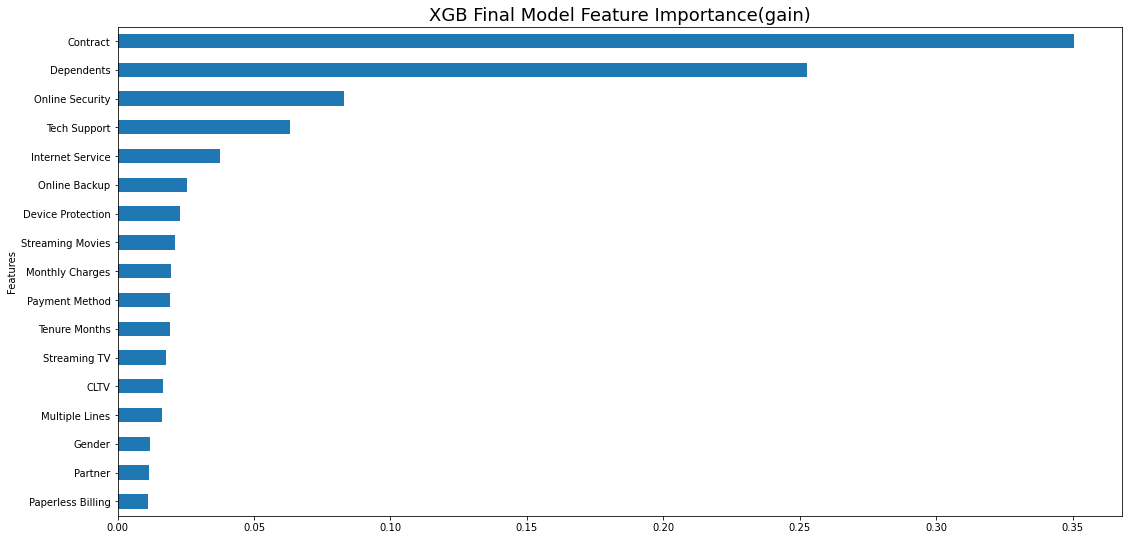

In [ ]:
## Feature importance
fea_imp_xgb = pd.Series(final_model.feature_importances_, index = X_train.columns)

# plot
fea_imp_xgb.sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('XGB Final Model Feature Importance(gain)', fontsize = 18);

##### **Observations**

- In general, the model reaches quite good performance with the test set, achieving an Accuracy of 99.2%.

- By analyzing the confusion matrix, we can see that the model is so good at identifying both classes Not Churn(1030 out of 1035) and Churn(368 out of 374) with 99.51% and 98.39% observations correctly classified respectly.

- Other metrics that show us the so good performance of the model with both classes:
 - ROC-AUC Score: 0.98
 - F1-Score: 0.98

- The variables that contribute most to the XGBoost final model were:
 - Contract
 - Dependents
 - Online security
 - Tech support 



### **Serialization**

In [ ]:
with open("customer_churn_xgb_model.pkl", "wb") as f:
  joblib.dump(final_model, f)